## [PyTorchを１から理解しながらMNISTの手書き数字認識モデルを作っていく！](https://qiita.com/TaigaMasuda/items/a5dc0d37ebfc9ac6400b)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

# jupyter notebook で画像を表示するためのマジックコマンド
%matplotlib inline 


In [27]:
# 訓練データ
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
# 検証データ
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

In [28]:
print("train_dataset\n", train_dataset)
print("\ntest_dataset\n", test_dataset)

train_dataset
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

test_dataset
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [29]:
# ミニバッチ学習をする。今回はバッチサイズは256にする
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True)

In [30]:
# 予測関数をクラスで定義する．
# PyTorchのニューラルネットワークの規定クラスであるnn.Moduleを継承するクラスを作る

class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):  # 順伝播 , xは入力データ
        z1 = F.relu(self.fc1(x))
        z2 = F.relu(self.fc2(z1))
        y = self.fc3(z2)
        # 後に出てくる[損失関数]に交差エントロピー誤差関数を使うので、出力層には活性化関数をかけない！！そのままyを返す
        return y

In [31]:
# 予測関数のインスタンス化
# データセット画像の大きさは28x28=784であるため、入力層のサイズは784
# 手書き数字の画像を0~9の10個に分類するタスクをするので、出力層のサイズは10
# 中間層は任意の値であるが、今回は中間層を2層にして、それぞれのサイズを1024と512にする

input_size = 784
hidden1_size = 1024
hidden2_size = 512
output_size = 10

# デバイスの設定 (MPS, CUDA, CPU)
if torch.backends.mps.is_available():  # Apple Silicon (MPS)
    device = torch.device("mps")
elif torch.cuda.is_available():  # NVIDIA GPU (CUDA)
    device = torch.device("cuda")
else:  # CPU
    device = torch.device("cpu")
print(f"Using device: {device}")

model = Net(input_size, hidden1_size, hidden2_size, output_size).to(device)
print(model)

Using device: cuda
Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [32]:
# 損失関数と最適化手法の設定
# 今回は，多値分類問題になるため，損失関数には，交差エントロピー誤差関数を、
# 最適化法には，確率的勾配降下法を用いて学習を行うこととする
# 交差エントロピー誤差関数を使うので、forwardに活性化関数が入ってないことに注意

# criterion : 基準
criterion = nn.CrossEntropyLoss()

# optimizer : 最適化
optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD : 確率的勾配降下法 , lr : 学習率

In [33]:
# 1エポック分を関数化して定義する
# ①予測計算↓
# ②損失計算↓
# ③勾配計算↓
# ④パラメータ更新

def train_model(model, train_loader, criterion, optimizer, device='cpu'):
    train_loss = 0.0  # trainの損失用の変数を定義
    num_train = 0  # 学習回数の記録用の変数を定義

    model.train()  # モデルを学習モードに設定

    # データの分割数分だけiterationを回す
    # バッチサイズ分のデータで1回パラメータを修正する

    for i, (images, labels) in enumerate(train_loader):
        num_train += len(labels)
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)

        optimizer.zero_grad()  # 勾配の初期化

        # 1. 順伝播(推論)
        outputs = model(images)  # 予測計算

        # 2. 損失計算
        loss = criterion(outputs, labels)

        # 3. 勾配計算
        loss.backward()  # 逆伝播, (勾配計算, 自動微分)

        # 4. パラメータ更新
        optimizer.step()

        # lossの加算
        train_loss += loss.item()

    train_loss = train_loss / num_train  # データ数で割って平均を取る
    return train_loss

In [34]:
# 検証データに対する予測精度を計算する関数を定義する

def test_model(model, test_loader, criterion, optimizer, device='cpu'):
    test_loss = 0.0
    num_test = 0

    model.eval()  # モデルを評価モードに設定

    with torch.no_grad():  # 自動微分を無効化(自動微分を使わなくていい。計算量を減らすために無効化)
        for _i, (images, labels) in enumerate(test_loader):
            num_test += len(labels)
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
        test_loss = test_loss / num_test

    return test_loss

In [35]:
# モデル学習を行う関数の定義
# 1エポックごとにテストデータでも評価を行い、学習データによる損失と、テストデータによる損失を出力する

def leaning(model, train_loader, test_loader, criterion, optimizer, num_epochs, device='cpu'):
    train_loss_list = []
    test_loss_list = []

    # epoch数分だけ学習をイテレートする
    for epoch in range(1, num_epochs+1):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        test_loss = test_model(model, test_loader, criterion, optimizer, device)

        print("epoch : {}, train_loss : {:.5f}, test_loss : {:.5f}" .format(epoch, train_loss, test_loss))

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    return train_loss_list, test_loss_list

In [36]:
# 学習を行う

num_epochs = 50
train_loss_list, test_loss_list = leaning(model,
                                          train_loader,
                                          test_loader,
                                          criterion,
                                          optimizer,
                                          num_epochs,
                                          device)

epoch : 1, train_loss : 0.04204, test_loss : 0.01882
epoch : 2, train_loss : 0.01712, test_loss : 0.01400
epoch : 3, train_loss : 0.01303, test_loss : 0.01122
epoch : 4, train_loss : 0.01036, test_loss : 0.00932
epoch : 5, train_loss : 0.00849, test_loss : 0.00773
epoch : 6, train_loss : 0.00710, test_loss : 0.00713


KeyboardInterrupt: 

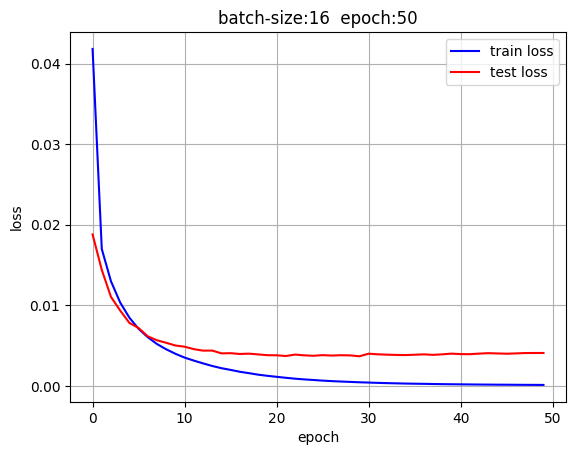

In [ ]:
# 学習推移の確認をグラフで行う

plt.title(f"batch-size:{batch_size}  epoch:{num_epochs}")
plt.plot(range(len(train_loss_list)), train_loss_list, c='b', label='train loss')
plt.plot(range(len(test_loss_list)), test_loss_list, c='r', label='test loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

label : 7, prediction : 7
label : 2, prediction : 2
label : 1, prediction : 1
label : 0, prediction : 0
label : 4, prediction : 4
label : 1, prediction : 1
label : 4, prediction : 4
label : 9, prediction : 9
label : 5, prediction : 5
label : 9, prediction : 9


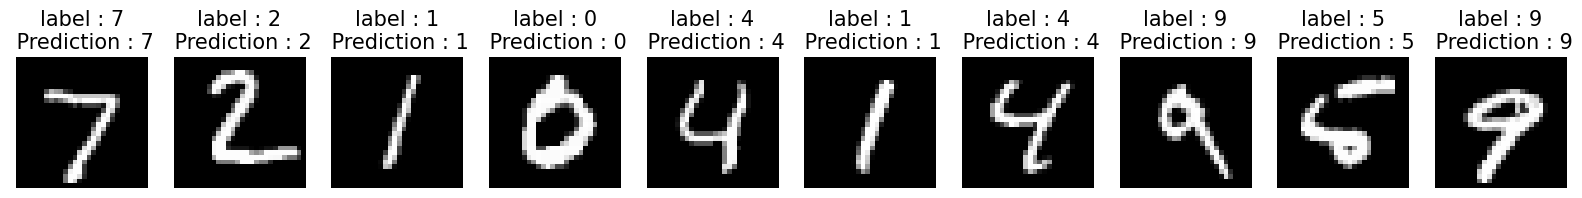

In [ ]:
# 上で学習したモデルをもとに、データを与えて実際に予測を行ってみる

# テストデータの1バッチ分のデータを取得
plt.figure(figsize=(20, 10))
for i in range(10):
    image, label = test_dataset[i]
    image = image.view(-1, 28*28).to(device)

    # 推論
    prediction_label = torch.argmax(model(image))
    print("label : {}, prediction : {}".format(label, prediction_label))

    ax = plt.subplot(1, 10, i+1)

    plt.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title('label : {}\n Prediction : {}'.format(label, prediction_label), fontsize=15)
plt.show()

In [ ]:
# モデルの保存 ONNX形式で
torch.onnx.export(model,  # モデル
                  torch.randn(1, 784).to(device),  # ダミーデータ
                  "mnist_model.onnx",  # 保存先
                  verbose=True  # ログの出力
                  )
       


Exported graph: graph(%onnx::Gemm_0 : Float(1, 784, strides=[784, 1], requires_grad=0, device=cuda:0),
      %fc1.weight : Float(1024, 784, strides=[784, 1], requires_grad=1, device=cuda:0),
      %fc1.bias : Float(1024, strides=[1], requires_grad=1, device=cuda:0),
      %fc2.weight : Float(512, 1024, strides=[1024, 1], requires_grad=1, device=cuda:0),
      %fc2.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %fc3.weight : Float(10, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %fc3.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0)):
  %/fc1/Gemm_output_0 : Float(1, 1024, strides=[1024, 1], requires_grad=1, device=cuda:0) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/fc1/Gemm"](%onnx::Gemm_0, %fc1.weight, %fc1.bias), scope: __main__.Net::/torch.nn.modules.linear.Linear::fc1 # /home/tomixrm/Dev/PyTorch_ws/pytorch-notebook/mnist_1/.venv/lib/python3.11/site-packages/torch/nn/modules/linear.py:125:0
  %/Relu_output_0 : Float(1, 10